## 로지스틱 회귀 분석
- Logistic Regression

- 적용 분류 기준
    1. 전처리
        - scailing(min-max)
        - log1p
    2. target 카테고리 개수
    3. 하이퍼 파라미터
        - C : 작을수록 규제 강도가 큼

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity="all"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

### 데이터 로드

In [3]:
CS = pd.read_csv('./data/CS.csv')
cs = CS.copy()

In [4]:
# 5~60대로 filtering
cs = cs[(cs['age'] == 5) | (cs['age'] == 6)]
# 수도권으로 filtering
cs = cs[(cs['sido'] == 1) | (cs['sido'] == 9)]

In [5]:
# filtering 확인
cs['age'].value_counts().index

Int64Index([5, 6], dtype='int64')

In [6]:
# filtering 확인
cs['sido'].value_counts().index

Int64Index([9, 1], dtype='int64')

In [7]:
# 데이터 세트 확인
cs

,view_cnt,where_cnt,attend_cnt,volunteer_cnt,history_cnt,festival_cnt,standard,block,expense,expense_f,...,festival,festival_f,sex,age,education,married,work,income,sido,disabled
0,49,0,0,0,5,0,1,1,14,14,...,2,6,2,5,3,1,5,3,1,1
1,3,3,3,0,1,0,2,6,14,9,...,2,7,2,5,3,2,5,7,1,1
6,22,15,0,0,0,0,2,2,14,14,...,2,5,2,5,4,3,1,5,1,1
7,10,0,0,0,2,2,2,4,17,11,...,1,6,1,5,4,2,1,6,1,1
9,7,0,0,0,0,0,3,2,15,12,...,2,5,2,5,3,2,1,5,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20595,21,0,0,0,0,0,5,4,14,14,...,2,5,1,5,4,2,1,3,9,1
20599,23,0,0,0,1,0,1,1,17,14,...,2,5,2,5,3,2,1,6,9,1
20605,30,1,0,0,1,0,4,1,8,8,...,2,4,2,6,2,2,3,4,9,1
20618,7,2,0,0,4,0,1,2,16,16,...,2,5,2,5,3,2,3,6,1,1


#### target 범주화

In [8]:
# 기존 데이터에 대한 기초통계량 출력
CS['view_cnt'].describe()

# 3개 카테고리로 나누기
# 1 : 문화예술행사 관람을 적게 하는 사람
# 2 : 문화예술행사 관람을 평범하게 하는 사람
# 3 : 문화예술행사 관람을 많이 하는 사람

count    20624.000000
mean        25.158505
std         37.865832
min          0.000000
25%          7.000000
50%         15.000000
75%         29.000000
max        730.000000
Name: view_cnt, dtype: float64

In [9]:
# target 범주화
target_min = min(CS['view_cnt'])
target_max = max(CS['view_cnt'])

target_ranges = [target_min-1, 7, 25, target_max+1]
labels = [1, 2, 3,]
cs['target'] = pd.cut(CS['view_cnt'], target_ranges, labels=labels)

In [10]:
# 범주화 확인
cs['target'].value_counts().sort_index()

1    743
2    967
3    434
Name: target, dtype: int64

### 전처리

#### feature / target 분류

In [11]:
# 연령과 거주지를 정하고 분석하기 때문에 제외
features = cs.drop(['view_cnt', 'age', 'sido', 'target'], axis=1)
target = cs['target']

#### 연속형 feature에 대해 스케일링 / log 변환

In [12]:
# 스케일링
# 추후 log 변환을 위하여
# 정규분포로 스케일링 하지 않고
# min-max 스케일링 실시
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
features.iloc[:, :5] = mms.fit_transform(features.iloc[:, :5])

# 스케일링 확인
features.iloc[:, :5].head(2)

,where_cnt,attend_cnt,volunteer_cnt,history_cnt,festival_cnt
0,0.000000,0.00,0.0,0.10,0.0
1,0.012195,0.03,0.0,0.02,0.0


In [13]:
# log 변환
features.iloc[:, :5] = np.log1p(features.iloc[:, :5])

# log 변환 확인
features.iloc[:, :5].head(2)

,where_cnt,attend_cnt,volunteer_cnt,history_cnt,festival_cnt
0,0.000000,0.000000,0.0,0.095310,0.0
1,0.012121,0.029559,0.0,0.019803,0.0


#### 범주형 변수 형변환

In [14]:
features.iloc[:, 5:] = features.iloc[:, 5:].astype(dtype='object')

In [15]:
features.iloc[:, 5:].dtypes

standard      object
block         object
expense       object
expense_f     object
difficulty    object
intention     object
history       object
history_f     object
festival      object
festival_f    object
sex           object
education     object
married       object
work          object
income        object
disabled      object
dtype: object

#### 범주형 변수에 대해 원-핫 인코딩

In [16]:
# 원-핫 인코딩 수행 
print('get_dummies() 수행 전 데이터 Shape', features.shape)

features = pd.get_dummies(features)
print('get_dummies() 수행 후 데이터 Shape', features.shape)

get_dummies() 수행 전 데이터 Shape (2144, 21)
get_dummies() 수행 후 데이터 Shape (2144, 111)


#### 데이터 세트 분리

In [17]:
# 데이터 세트 분리
from sklearn.model_selection import train_test_split

X_train , X_test , y_train , y_test = train_test_split(features, 
                                                       target, 
                                                       test_size=0.2, 
                                                       random_state=0)

## 로지스틱 회귀 모델링
- Elastic-Net 사용을 위해 최적화에 사용하는 알고리즘으로 saga 사용

In [18]:
# 하이퍼 파라미터 설정 최적 평균 정확도 확인

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score

def print_params(cv, parameters):
    lr_clf = LogisticRegression(solver='saga')
    
    grid_lclf = GridSearchCV(lr_clf, param_grid=parameters, scoring='accuracy', cv=cv)
    grid_lclf.fit(X_train, y_train)

    best_lclf = grid_lclf.best_estimator_

    # 최적 하이퍼 파라미터로 학습된 Estimator로 예측/평가 수행
    y_pred = best_lclf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # 최종 출력 결과
    print('cv{0} 최적 하이퍼 파라미터 : {1}'.format(cv, grid_lclf.best_params_))
    print('cv{0} 정확도 : {1:.4f}'.format(cv, grid_lclf.best_score_))
    print('cv{0} Best Estimator 정확도 : {1:.4f}'.format(cv, accuracy))
    print('')

In [19]:
# 파라미터 설정
parameters = {
    'max_iter' : [500, 1000],
    'penalty' : ['l2', 'l1'],
    'C' : [0.01, 0.05, 0.1, 0.5, 1, 5, 10],
}

In [20]:
# 교차 검증
for cv in range(3, 9):
    print_params(cv, parameters)

cv3 최적 하이퍼 파라미터 : {'C': 0.5, 'max_iter': 500, 'penalty': 'l1'}
cv3 정확도 : 0.5236
cv3 Best Estimator 정확도 : 0.4779

cv4 최적 하이퍼 파라미터 : {'C': 0.1, 'max_iter': 500, 'penalty': 'l2'}
cv4 정확도 : 0.5190
cv4 Best Estimator 정확도 : 0.4615

cv5 최적 하이퍼 파라미터 : {'C': 1, 'max_iter': 500, 'penalty': 'l1'}
cv5 정확도 : 0.5137
cv5 Best Estimator 정확도 : 0.4732

cv6 최적 하이퍼 파라미터 : {'C': 1, 'max_iter': 500, 'penalty': 'l2'}
cv6 정확도 : 0.5271
cv6 Best Estimator 정확도 : 0.4685

cv7 최적 하이퍼 파라미터 : {'C': 1, 'max_iter': 500, 'penalty': 'l2'}
cv7 정확도 : 0.5149
cv7 Best Estimator 정확도 : 0.4685

cv8 최적 하이퍼 파라미터 : {'C': 1, 'max_iter': 500, 'penalty': 'l2'}
cv8 정확도 : 0.5201
cv8 Best Estimator 정확도 : 0.4685



- 가장 높은 정확도를 보인 모델의 정확도는 0.5271로
- l2 패널티를 부여했다.
- 따라서 l2 패널티(Ridge)에 더 높은 가중치를 주어
- Elastic-Net을 적용한다.

In [22]:
# 파라미터 설정
parameters = {
    'max_iter' : [500, 1000],
    'penalty' : ['elasticnet',],
    'C' : [0.1, 0.5, 1, 5, 10],
    # 1에 가까울수록 l1 규제 가중치가 커짐
    'l1_ratio' : [0, 0.1, 0.25, 0.3, 0.5],
}

In [24]:
# 교차 검증
for cv in range(3, 8):
    print_params(cv, parameters)

cv3 최적 하이퍼 파라미터 : {'C': 0.5, 'l1_ratio': 0.5, 'max_iter': 500, 'penalty': 'elasticnet'}
cv3 정확도 : 0.5236
cv3 Best Estimator 정확도 : 0.4755

cv4 최적 하이퍼 파라미터 : {'C': 0.1, 'l1_ratio': 0, 'max_iter': 500, 'penalty': 'elasticnet'}
cv4 정확도 : 0.5190
cv4 Best Estimator 정확도 : 0.4615

cv5 최적 하이퍼 파라미터 : {'C': 1, 'l1_ratio': 0.5, 'max_iter': 500, 'penalty': 'elasticnet'}
cv5 정확도 : 0.5149
cv5 Best Estimator 정확도 : 0.4662

cv6 최적 하이퍼 파라미터 : {'C': 1, 'l1_ratio': 0.1, 'max_iter': 500, 'penalty': 'elasticnet'}
cv6 정확도 : 0.5294
cv6 Best Estimator 정확도 : 0.4662

cv7 최적 하이퍼 파라미터 : {'C': 1, 'l1_ratio': 0, 'max_iter': 500, 'penalty': 'elasticnet'}
cv7 정확도 : 0.5149
cv7 Best Estimator 정확도 : 0.4685



- 교차 검증 집단 개수는 6 이고 최대 반복횟수가 500 으로 충분하며,
- Elastic-Net 방식을 이용했을 때,
- 전체 규제 가중치는 1, Ridge : Lasso 비율은 9 : 1 일 때
- 가장 높은 정확도인 0.5294를 나타냈다.
- 더 높은 성능의 모델의 파라미터 값을 위해 l1_ratio를 좁혀서 모델링한다.

In [27]:
# 파라미터 설정
parameters = {
    'max_iter' : [500],
    'penalty' : ['elasticnet',],
    # 'C' : [1],  # defalt 값이므로 생략
    # 1에 가까울수록 l1 규제 가중치가 커짐
    'l1_ratio' : [0.05, 0.1, 0.15, 0.2],
}

In [28]:
# 교차 검증
for cv in [6,]:
    print_params(cv, parameters)

cv6 최적 하이퍼 파라미터 : {'l1_ratio': 0.1, 'max_iter': 500, 'penalty': 'elasticnet'}
cv6 정확도 : 0.5294
cv6 Best Estimator 정확도 : 0.4662



- Ridge : Lasso 비율은 그대로 9 : 1 일 때
- 가장 높은 정확도를 보인다.

In [21]:
# 최종 모델 결과 출력
lr_clf = LogisticRegression(solver='saga',
                            penalty='elasticnet',
                            l1_ratio=0.1
                           )

lr_clf.fit(X_train, y_train)

# 최적 하이퍼 파라미터로 학습된 Estimator로 예측/평가 수행
y_pred = lr_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

# 최종 출력 결과
print('Logistic Regression - Elastic-Net : {0:.4f}'.format(accuracy))

LogisticRegression(l1_ratio=0.1, penalty='elasticnet', solver='saga')

Logistic Regression - Elastic-Net : 0.4662


### 회귀계수 분석

In [39]:
# # 회귀 계수 출력
# # 가설 함수가 3개가 나오므로 3차원
# lr_clf.coef_

In [38]:
# # feature name 출력
# lr_clf.feature_names_in_

In [51]:
# 회귀 계수 시각화 함수
def visualize_coefficient(model):
    # 3개의 가설 함수 시각화를 위해 3개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=3)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 회귀 계수 시각화. 
    for i_num, coefs in enumerate(model.coef_):
        # feature 이름과 회귀 계수를 하나의 데이터프레임으로 생성 후 정렬
        # coef에는 절대값 적용
        df = pd.DataFrame({
            'feature' : model.feature_names_in_,
            'coef' : abs(coefs),
        }).sort_values(by=['coef'], ascending=False)
        
        # 상위 10개 도출
        coef_top10 = df[:10]
        
        # 순차적으로 ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정. 
        axs[i_num].set_title(model.__class__.__name__ +' Coeffiecents', size=25)
        axs[i_num].tick_params(axis="y",direction="in", pad=-120) # 안쪽, 패딩값
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(30)
        sns.barplot(x=coef_top10['coef'], y=coef_top10['feature'] , ax=axs[i_num])

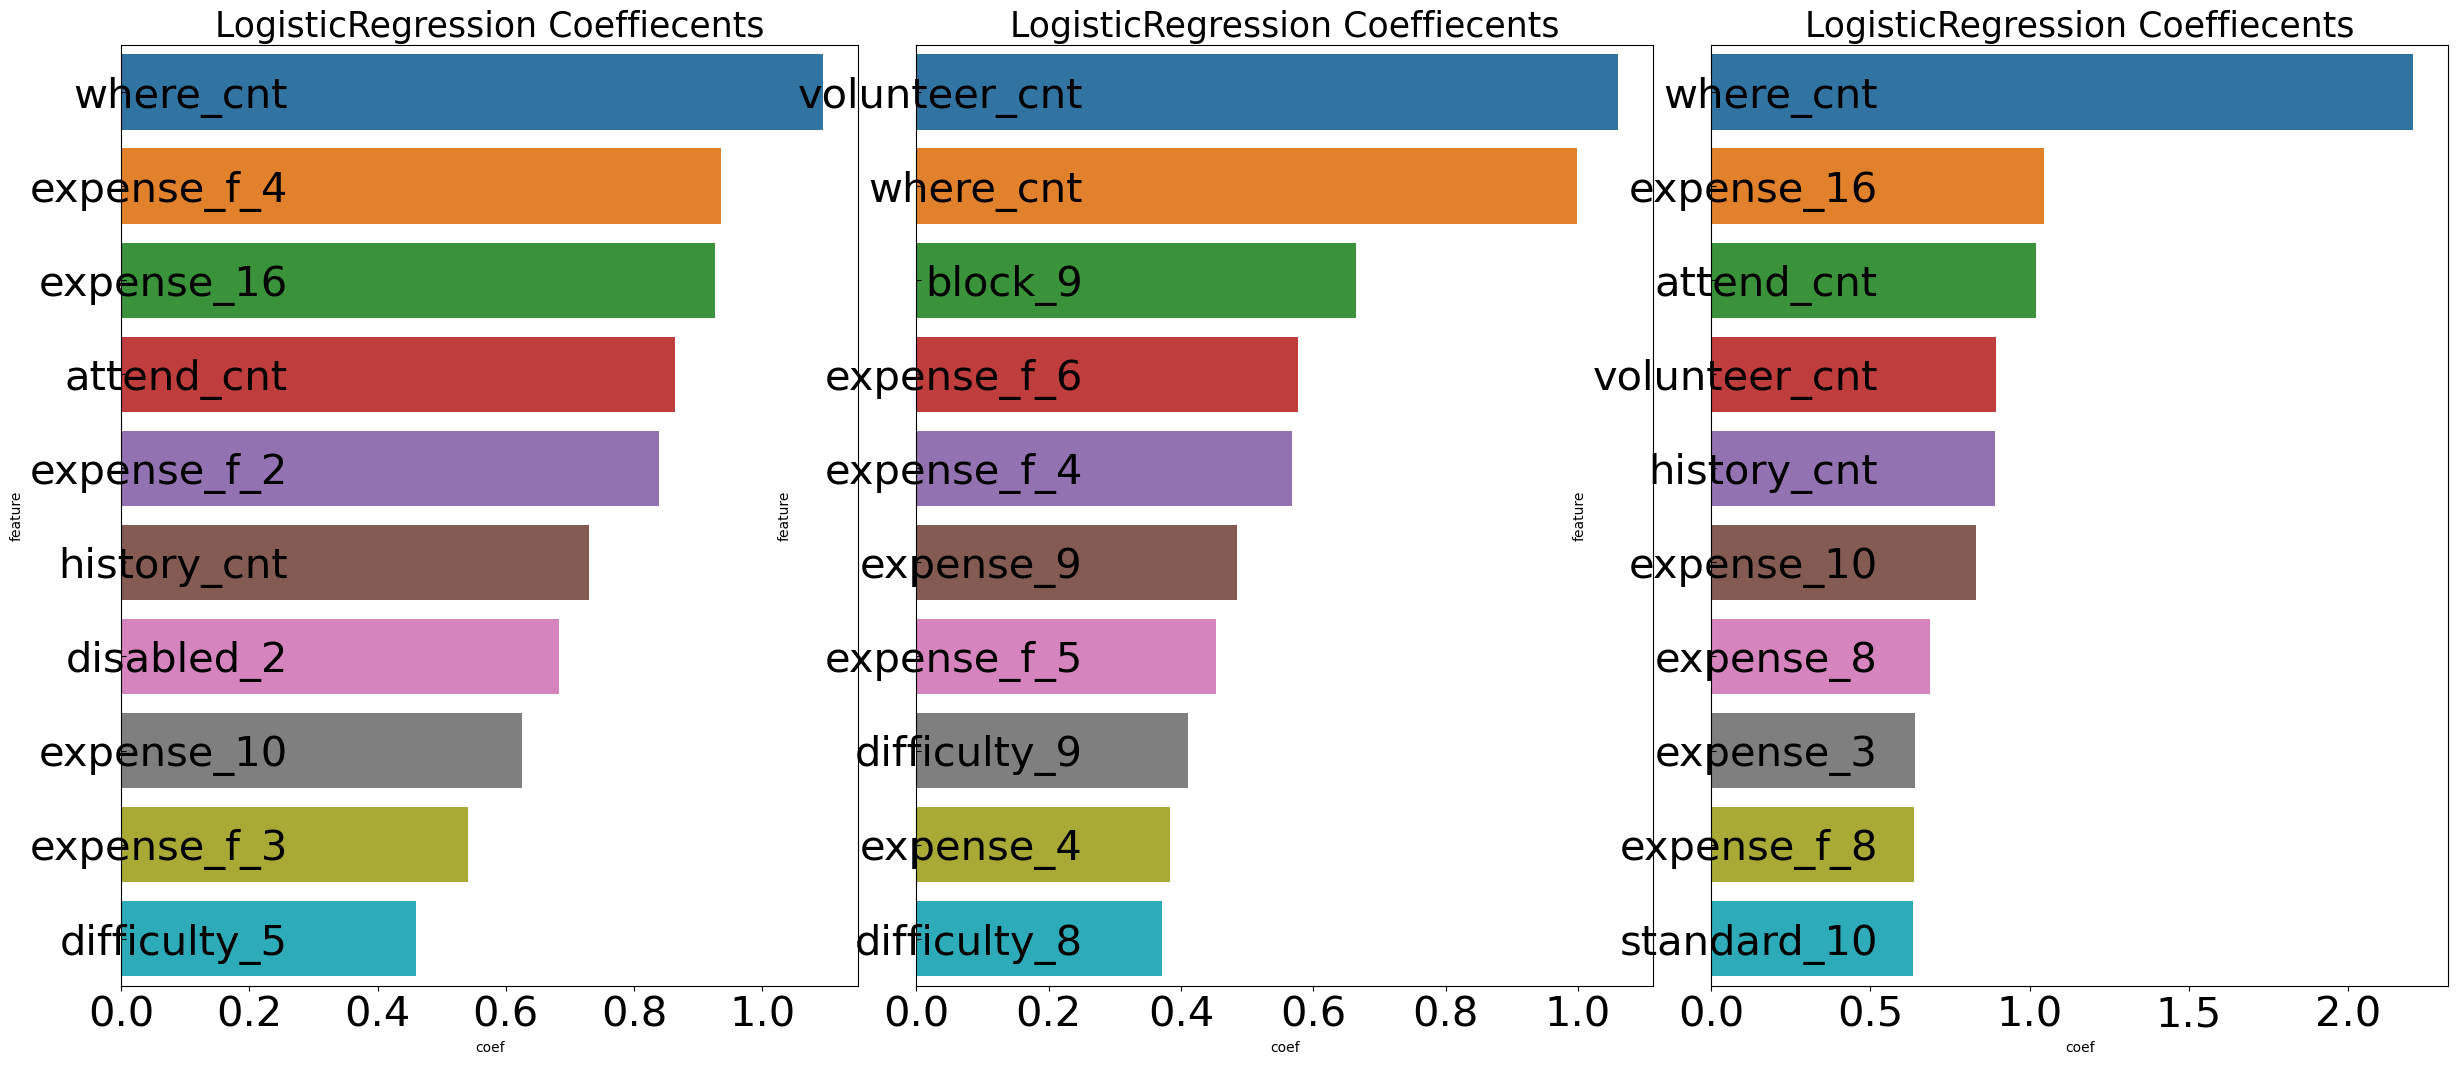

In [52]:
model = lr_clf
visualize_coefficient(model)

## 결론
- 로지스틱 회귀분석 결과
- Ridge : Lasso 비율이 9 : 1 로 설정한 Elastic-Net을 이용했을 때,
- 정확도 0.4662의 모델이 도출되었다.
---
- 적게 관람하는 사람들(1), 많이 관람하는 사람들(3)의 회귀계수가 비슷하다.
- where_cnt, expense_16, attend_cnt, history_cnt, expense_10이 공통적으로 높다.